# 환경설정

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-a3535acd6724>", line 8, in <module>
    import tensorflow as tf
  File "/usr/local/lib/python3.7/site-packages/tensorflow/__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/__init__.py", line 73, in <module>
    from tensorflow.python.tpu import api
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/tpu/api.py", line 29, in <module>
    from tensorflow.python.tpu import tpu_embedding
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/tpu/tpu_embedding.py", line 28, in <module>
    from tensorflow.core.protobuf.tpu import optimization_parameters_pb2
  File "/usr/local/lib/python3.7/site-packages/tensorflow/core/protobuf/tpu/optim

TypeError: object of type 'NoneType' has no len()

In [ ]:
with open('df_scaled_UTD.pickle','rb') as f:
    df_scaled = pickle.load(f)
with open('sector.pickle','rb') as f:
    sector = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_dic = {}
X_test_dic={}
y_train_dic = {}
y_test_dic = {}
#모델이 각 업종마다 존재한다. 18개
for sector_name, df in df_scaled.items():
    # 단 셔플 없이 분할
    X_train, X_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)
    X_train_dic[sector_name] = X_train
    X_test_dic[sector_name] = X_test
    y_train_dic[sector_name] = y_train
    y_test_dic[sector_name] = y_test

In [ ]:
X_train_dic['Food'].shape, y_train_dic['Food'].shape

In [ ]:
X_test_dic['Food'].shape, y_test_dic['Food'].shape

# 윈도우 데이터 셋 생성

In [6]:
# 윈도우 데이터셋 생성 함수
def windowed_dataset(X, y, X_size, y_size, X_shift, y_shift, X_stride, y_stride, batch_size):
    
    # numpy array x(input)를 Dataset으로 변환
    ds_x = tf.data.Dataset.from_tensor_slices(X)
    
    #윈도우셋 구성
    ds_x = ds_x.window(size=X_size,stride=X_stride, shift=X_shift, drop_remainder=True)
    #한 차원 줄야사 반환
    ds_x = ds_x.flat_map(lambda x: x.batch(X_size))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds_y = ds_y.window(size=y_size, stride=y_stride, shift=y_shift, drop_remainder=True)
    ds_y = ds_y.flat_map(lambda y: y.batch(y_size))
    
    #같은 인덱스에 있는 애들 끼리 묶기
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    return ds.batch(batch_size).prefetch(1)

## 파라미터 지정

In [7]:
#윈도우 사이즈
WINDOW_SIZE = 10
# X에 대한 윈도우 함수 설정값
X_size = WINDOW_SIZE
X_shift = 10
X_stride = 1
# y에 대한 윈도우 함수 설정값
y_size = 1
y_shift = WINDOW_SIZE
y_stride = 1

batch_size = 1

In [8]:
tf_dataset_train_dic={}
for sector_name, X_train in X_train_dic.items():
    y_train = y_train_dic[sector_name]
    tf_dataset_train_dic[sector_name] = windowed_dataset(X_train,y_train[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

tf_dataset_test_dic = {}
for sector_name, X_test in X_test_dic.items():
    y_test = y_test_dic[sector_name]
    tf_dataset_test_dic[sector_name] = windowed_dataset(X_test,y_test[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

    # 데이터 shape, 미리보기로 체크
for x, y in tf_dataset_train_dic['Food'].take(3):
    print('X:', x.shape)
    print(x)
    print()
    print('Y:', y.shape)
    print(y)
    print('-'*100)

X: (1, 10, 4)
tf.Tensor(
[[[0.04225737 0.05670212 0.0438025  0.08195749]
  [0.06395201 0.05739598 0.04494543 0.08973443]
  [0.03599058 0.06502842 0.04208812 0.095426  ]
  [0.02599399 0.07682402 0.05366021 0.10291491]
  [0.02091734 0.06884187 0.0487285  0.10399217]
  [0.0379419  0.0818198  0.05966055 0.10730457]
  [0.01763888 0.07952729 0.05323161 0.10298404]
  [0.01986691 0.05850615 0.03965941 0.09629011]
  [0.01642815 0.06356854 0.03887079 0.09088657]
  [0.01617651 0.05857276 0.03865935 0.09304683]]], shape=(1, 10, 4), dtype=float64)

Y: (1, 1)
tf.Tensor([[0.0882742]], shape=(1, 1), dtype=float64)
----------------------------------------------------------------------------------------------------
X: (1, 10, 4)
tf.Tensor(
[[[0.02629668 0.06148697 0.04708841 0.09773028]
  [0.03018051 0.06891403 0.05023144 0.10104269]
  [0.02009616 0.07196701 0.05437454 0.10910767]
  [0.00832109 0.07751787 0.05337448 0.11112391]
  [0.01355087 0.07286625 0.04929996 0.10651535]
  [0.02565281 0.0709956  0.0

## 모델

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
model_dic ={}
for sector_name in sector.keys():
    model_dic[sector_name] = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=32, kernel_size=5,
               padding="causal",
               activation="relu",
               #feature의 개수 3개
               input_shape=[WINDOW_SIZE, 4]),
        # LSTM
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])

In [11]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
for sector_model in model_dic.values():
    sector_model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [12]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [13]:
# val_loss 기준 체크포인터도 생성합니다.
filename_dic={}
for sector_name in sector.keys():
    filename_dic[sector_name] = os.path.join('Models', sector_name+'ckeckpointer.ckpt')

In [14]:
#체크포인트를 저장    
mc_dic = {}
for sector_name in filename_dic:
    mc_dic[sector_name] = ModelCheckpoint(filename_dic[sector_name], 
                         save_weights_only=True, 
                         save_best_only=True, 
                         monitor='val_loss', 
                         verbose=1)

In [15]:
history_dic={}
# 학습+저장
for sector_name, train_data in tf_dataset_train_dic.items():
    test_data = tf_dataset_test_dic[sector_name]
    history = model_dic[sector_name].fit(train_data, 
                        validation_data=(test_data), 
                        epochs=50, 
                        callbacks=[mc_dic[sector_name], earlystopping])
    history_dic[sector_name] = history
with open('history_dic.pickle', 'wb') as f:
    pickle.dump(history_dic,f)

Epoch 1/50
    228/Unknown - 4s 4ms/step - loss: 0.0011 - mse: 0.0022
Epoch 1: val_loss improved from inf to 0.00347, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 6s 13ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 0.0035 - val_mse: 0.0069
Epoch 2/50
235/239 [============================>.] - ETA: 0s - loss: 8.9124e-04 - mse: 0.0018
Epoch 2: val_loss improved from 0.00347 to 0.00232, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 8.7835e-04 - mse: 0.0018 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 3/50
234/239 [============================>.] - ETA: 0s - loss: 8.1143e-04 - mse: 0.0016
Epoch 3: val_loss improved from 0.00232 to 0.00151, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 7.9661e-04 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 4/50
236/239 [============================>.] - ETA: 0s - loss: 7.5792e-04 

231/239 [===========================>..] - ETA: 0s - loss: 6.0180e-04 - mse: 0.0012
Epoch 27: val_loss improved from 0.00045 to 0.00044, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.8427e-04 - mse: 0.0012 - val_loss: 4.3753e-04 - val_mse: 8.7505e-04
Epoch 28/50
237/239 [============================>.] - ETA: 0s - loss: 5.6726e-04 - mse: 0.0011
Epoch 28: val_loss improved from 0.00044 to 0.00042, saving model to Models\Foodckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.6253e-04 - mse: 0.0011 - val_loss: 4.1863e-04 - val_mse: 8.3726e-04
Epoch 29/50
237/239 [============================>.] - ETA: 0s - loss: 5.5797e-04 - mse: 0.0011
Epoch 29: val_loss did not improve from 0.00042
239/239 [==============================] - 1s 5ms/step - loss: 5.5331e-04 - mse: 0.0011 - val_loss: 4.3094e-04 - val_mse: 8.6187e-04
Epoch 30/50
229/239 [===========================>..] - ETA: 0s - loss: 5.4881e-04

239/239 [==============================] - 1s 5ms/step - loss: 5.7780e-04 - mse: 0.0012 - val_loss: 0.0442 - val_mse: 0.0885
Epoch 5/50
233/239 [============================>.] - ETA: 0s - loss: 6.5936e-04 - mse: 0.0013
Epoch 5: val_loss improved from 0.04425 to 0.03893, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.7143e-04 - mse: 0.0013 - val_loss: 0.0389 - val_mse: 0.0779
Epoch 6/50
239/239 [==============================] - ETA: 0s - loss: 5.1258e-04 - mse: 0.0010   
Epoch 6: val_loss improved from 0.03893 to 0.03702, saving model to Models\Clothingckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.1258e-04 - mse: 0.0010 - val_loss: 0.0370 - val_mse: 0.0740
Epoch 7/50
236/239 [============================>.] - ETA: 0s - loss: 3.5383e-04 - mse: 7.0766e-04
Epoch 7: val_loss improved from 0.03702 to 0.03424, saving model to Models\Clothingckeckpointer.ckpt
239/239 [=====================

239/239 [==============================] - 1s 5ms/step - loss: 3.9598e-04 - mse: 7.9195e-04 - val_loss: 0.0154 - val_mse: 0.0309
Epoch 14/50
233/239 [============================>.] - ETA: 0s - loss: 3.8861e-04 - mse: 7.7722e-04
Epoch 14: val_loss improved from 0.01544 to 0.01538, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.8748e-04 - mse: 7.7496e-04 - val_loss: 0.0154 - val_mse: 0.0308
Epoch 15/50
233/239 [============================>.] - ETA: 0s - loss: 3.8977e-04 - mse: 7.7954e-04
Epoch 15: val_loss improved from 0.01538 to 0.01529, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.8854e-04 - mse: 7.7709e-04 - val_loss: 0.0153 - val_mse: 0.0306
Epoch 16/50
232/239 [============================>.] - ETA: 0s - loss: 3.8818e-04 - mse: 7.7636e-04
Epoch 16: val_loss improved from 0.01529 to 0.01518, saving model to Models\Chemicalckeckpointer.ckpt
239/239

239/239 [==============================] - 1s 5ms/step - loss: 2.4772e-04 - mse: 4.9543e-04 - val_loss: 0.0101 - val_mse: 0.0202
Epoch 39/50
228/239 [===========================>..] - ETA: 0s - loss: 2.4573e-04 - mse: 4.9147e-04
Epoch 39: val_loss improved from 0.01008 to 0.00977, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.4338e-04 - mse: 4.8677e-04 - val_loss: 0.0098 - val_mse: 0.0195
Epoch 40/50
229/239 [===========================>..] - ETA: 0s - loss: 2.3393e-04 - mse: 4.6787e-04
Epoch 40: val_loss improved from 0.00977 to 0.00946, saving model to Models\Chemicalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.3292e-04 - mse: 4.6583e-04 - val_loss: 0.0095 - val_mse: 0.0189
Epoch 41/50
233/239 [============================>.] - ETA: 0s - loss: 2.2734e-04 - mse: 4.5467e-04
Epoch 41: val_loss improved from 0.00946 to 0.00916, saving model to Models\Chemicalckeckpointer.ckpt
239/239

239/239 [==============================] - 1s 5ms/step - loss: 5.6714e-04 - mse: 0.0011 - val_loss: 0.0170 - val_mse: 0.0341
Epoch 15/50
236/239 [============================>.] - ETA: 0s - loss: 5.5614e-04 - mse: 0.0011  
Epoch 15: val_loss improved from 0.01705 to 0.01696, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.5744e-04 - mse: 0.0011 - val_loss: 0.0170 - val_mse: 0.0339
Epoch 16/50
229/239 [===========================>..] - ETA: 0s - loss: 5.4047e-04 - mse: 0.0011   
Epoch 16: val_loss improved from 0.01696 to 0.01693, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.4469e-04 - mse: 0.0011 - val_loss: 0.0169 - val_mse: 0.0339
Epoch 17/50
233/239 [============================>.] - ETA: 0s - loss: 4.9914e-04 - mse: 9.9829e-04
Epoch 17: val_loss improved from 0.01693 to 0.01616, saving model to Models\Medicineckeckpointer.ckpt
239/239 [=============

Epoch 40/50
237/239 [============================>.] - ETA: 0s - loss: 3.4431e-04 - mse: 6.8862e-04
Epoch 40: val_loss improved from 0.01121 to 0.01100, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.4478e-04 - mse: 6.8957e-04 - val_loss: 0.0110 - val_mse: 0.0220
Epoch 41/50
239/239 [==============================] - ETA: 0s - loss: 3.3780e-04 - mse: 6.7559e-04
Epoch 41: val_loss improved from 0.01100 to 0.01056, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.3780e-04 - mse: 6.7559e-04 - val_loss: 0.0106 - val_mse: 0.0211
Epoch 42/50
238/239 [============================>.] - ETA: 0s - loss: 3.2676e-04 - mse: 6.5352e-04
Epoch 42: val_loss improved from 0.01056 to 0.01042, saving model to Models\Medicineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.2711e-04 - mse: 6.5421e-04 - val_loss: 0.0104 - val_mse: 0.0208
Epoch 4

Epoch 16/50
239/239 [==============================] - ETA: 0s - loss: 2.0044e-04 - mse: 4.0088e-04
Epoch 16: val_loss did not improve from 0.03414
239/239 [==============================] - 1s 5ms/step - loss: 2.0044e-04 - mse: 4.0088e-04 - val_loss: 0.0365 - val_mse: 0.0729
Epoch 17/50
236/239 [============================>.] - ETA: 0s - loss: 2.1635e-04 - mse: 4.3271e-04
Epoch 17: val_loss did not improve from 0.03414
239/239 [==============================] - 1s 5ms/step - loss: 2.1579e-04 - mse: 4.3157e-04 - val_loss: 0.0351 - val_mse: 0.0702
Epoch 18/50
235/239 [============================>.] - ETA: 0s - loss: 1.9349e-04 - mse: 3.8697e-04
Epoch 18: val_loss improved from 0.03414 to 0.03167, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.9270e-04 - mse: 3.8539e-04 - val_loss: 0.0317 - val_mse: 0.0633
Epoch 19/50
239/239 [==============================] - ETA: 0s - loss: 1.9329e-04 - mse: 3.8658e-04
Epoch 19: val_

Epoch 42/50
237/239 [============================>.] - ETA: 0s - loss: 1.2495e-04 - mse: 2.4990e-04
Epoch 42: val_loss improved from 0.01854 to 0.01767, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.2560e-04 - mse: 2.5120e-04 - val_loss: 0.0177 - val_mse: 0.0353
Epoch 43/50
239/239 [==============================] - ETA: 0s - loss: 1.1559e-04 - mse: 2.3118e-04
Epoch 43: val_loss improved from 0.01767 to 0.01759, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.1559e-04 - mse: 2.3118e-04 - val_loss: 0.0176 - val_mse: 0.0352
Epoch 44/50
232/239 [============================>.] - ETA: 0s - loss: 1.1342e-04 - mse: 2.2684e-04
Epoch 44: val_loss improved from 0.01759 to 0.01654, saving model to Models\Non_Metalckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.1244e-04 - mse: 2.2487e-04 - val_loss: 0.0165 - val_mse: 0.0331
Epoc

Epoch 19/50
231/239 [===========================>..] - ETA: 0s - loss: 6.6947e-04 - mse: 0.0013
Epoch 19: val_loss did not improve from 0.00084
239/239 [==============================] - 1s 5ms/step - loss: 6.5096e-04 - mse: 0.0013 - val_loss: 9.7151e-04 - val_mse: 0.0019
Epoch 20/50
229/239 [===========================>..] - ETA: 0s - loss: 6.5553e-04 - mse: 0.0013
Epoch 20: val_loss did not improve from 0.00084
239/239 [==============================] - 1s 5ms/step - loss: 6.3265e-04 - mse: 0.0013 - val_loss: 9.9524e-04 - val_mse: 0.0020
Epoch 1/50
    229/Unknown - 3s 4ms/step - loss: 0.0090 - mse: 0.0179
Epoch 1: val_loss improved from inf to 0.05391, saving model to Models\Machineckeckpointer.ckpt
239/239 [==============================] - 4s 7ms/step - loss: 0.0086 - mse: 0.0172 - val_loss: 0.0539 - val_mse: 0.1078
Epoch 2/50
233/239 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 0.0053
Epoch 2: val_loss improved from 0.05391 to 0.03751, saving model to Models\M

239/239 [==============================] - 1s 5ms/step - loss: 5.2064e-04 - mse: 0.0010 - val_loss: 0.0093 - val_mse: 0.0186
Epoch 27/50
238/239 [============================>.] - ETA: 0s - loss: 5.1274e-04 - mse: 0.0010
Epoch 27: val_loss improved from 0.00930 to 0.00883, saving model to Models\Machineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.1062e-04 - mse: 0.0010 - val_loss: 0.0088 - val_mse: 0.0177
Epoch 28/50
238/239 [============================>.] - ETA: 0s - loss: 4.9851e-04 - mse: 9.9701e-04
Epoch 28: val_loss did not improve from 0.00883
239/239 [==============================] - 1s 5ms/step - loss: 4.9645e-04 - mse: 9.9290e-04 - val_loss: 0.0089 - val_mse: 0.0177
Epoch 29/50
228/239 [===========================>..] - ETA: 0s - loss: 5.1352e-04 - mse: 0.0010
Epoch 29: val_loss improved from 0.00883 to 0.00878, saving model to Models\Machineckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.9170e-04 - mse

239/239 [==============================] - ETA: 0s - loss: 2.2226e-04 - mse: 4.4451e-04
Epoch 3: val_loss improved from 0.04112 to 0.03920, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 2.2226e-04 - mse: 4.4451e-04 - val_loss: 0.0392 - val_mse: 0.0784
Epoch 4/50
231/239 [===========================>..] - ETA: 0s - loss: 1.3524e-04 - mse: 2.7048e-04
Epoch 4: val_loss improved from 0.03920 to 0.03557, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.4208e-04 - mse: 2.8416e-04 - val_loss: 0.0356 - val_mse: 0.0711
Epoch 5/50
239/239 [==============================] - ETA: 0s - loss: 1.0615e-04 - mse: 2.1231e-04
Epoch 5: val_loss improved from 0.03557 to 0.03224, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.0615e-04 - mse: 2.1231e-04 - val_loss: 0.0322 - val_mse: 0.0645
Epoch 6/50
238/239

Epoch 28/50
238/239 [============================>.] - ETA: 0s - loss: 5.6506e-05 - mse: 1.1301e-04
Epoch 28: val_loss improved from 0.01448 to 0.01416, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.7910e-05 - mse: 1.1582e-04 - val_loss: 0.0142 - val_mse: 0.0283
Epoch 29/50
239/239 [==============================] - ETA: 0s - loss: 5.7913e-05 - mse: 1.1583e-04
Epoch 29: val_loss improved from 0.01416 to 0.01357, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.7913e-05 - mse: 1.1583e-04 - val_loss: 0.0136 - val_mse: 0.0271
Epoch 30/50
228/239 [===========================>..] - ETA: 0s - loss: 5.3653e-05 - mse: 1.0731e-04
Epoch 30: val_loss improved from 0.01357 to 0.01323, saving model to Models\Electronicckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.7317e-05 - mse: 1.1463e-04 - val_loss: 0.0132 - val_mse: 0.0265
E

Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0044
Epoch 3: val_loss improved from 0.00079 to 0.00058, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 5.8047e-04 - val_mse: 0.0012
Epoch 4/50
231/239 [===========================>..] - ETA: 0s - loss: 0.0020 - mse: 0.0040
Epoch 4: val_loss improved from 0.00058 to 0.00043, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0020 - mse: 0.0039 - val_loss: 4.3386e-04 - val_mse: 8.6773e-04
Epoch 5/50
231/239 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.0036
Epoch 5: val_loss improved from 0.00043 to 0.00034, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 3.3522e-04 - val_mse: 6.7044e-04
Epoch 6/50
237/239 [=========

239/239 [==============================] - 1s 5ms/step - loss: 5.8854e-04 - mse: 0.0012 - val_loss: 1.5691e-04 - val_mse: 3.1383e-04
Epoch 29/50
236/239 [============================>.] - ETA: 0s - loss: 5.7989e-04 - mse: 0.0012
Epoch 29: val_loss did not improve from 0.00016
239/239 [==============================] - 1s 5ms/step - loss: 5.7454e-04 - mse: 0.0011 - val_loss: 1.5770e-04 - val_mse: 3.1539e-04
Epoch 30/50
229/239 [===========================>..] - ETA: 0s - loss: 5.8071e-04 - mse: 0.0012
Epoch 30: val_loss improved from 0.00016 to 0.00015, saving model to Models\Constructionckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.5959e-04 - mse: 0.0011 - val_loss: 1.5263e-04 - val_mse: 3.0526e-04
Epoch 31/50
233/239 [============================>.] - ETA: 0s - loss: 5.5725e-04 - mse: 0.0011
Epoch 31: val_loss did not improve from 0.00015
239/239 [==============================] - 1s 5ms/step - loss: 5.4550e-04 - mse: 0.0011 - val_loss: 1.6027e-04 

Epoch 6/50
228/239 [===========================>..] - ETA: 0s - loss: 0.0346 - mse: 0.0692
Epoch 6: val_loss did not improve from 0.00152
239/239 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0676 - val_loss: 0.0059 - val_mse: 0.0119
Epoch 7/50
231/239 [===========================>..] - ETA: 0s - loss: 0.0342 - mse: 0.0683
Epoch 7: val_loss did not improve from 0.00152
239/239 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0672 - val_loss: 0.0062 - val_mse: 0.0125
Epoch 8/50
235/239 [============================>.] - ETA: 0s - loss: 0.0338 - mse: 0.0675
Epoch 8: val_loss did not improve from 0.00152
239/239 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0670 - val_loss: 0.0064 - val_mse: 0.0129
Epoch 9/50
230/239 [===========================>..] - ETA: 0s - loss: 0.0340 - mse: 0.0681
Epoch 9: val_loss did not improve from 0.00152
239/239 [==============================] - 1s 5ms/step - loss: 0.0334 - mse: 0.0669 -

Epoch 23/50
234/239 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0035
Epoch 23: val_loss did not improve from 0.00012
239/239 [==============================] - 1s 5ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 1.2585e-04 - val_mse: 2.5170e-04
Epoch 24/50
235/239 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 24: val_loss did not improve from 0.00012
239/239 [==============================] - 1s 5ms/step - loss: 0.0017 - mse: 0.0033 - val_loss: 1.3265e-04 - val_mse: 2.6529e-04
Epoch 25/50
238/239 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0033
Epoch 25: val_loss did not improve from 0.00012
239/239 [==============================] - 1s 5ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 1.3373e-04 - val_mse: 2.6745e-04
Epoch 26/50
228/239 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 0.0033
Epoch 26: val_loss did not improve from 0.00012
239/239 [==============================] - 1s 5ms/ste

239/239 [==============================] - 1s 5ms/step - loss: 3.8036e-04 - mse: 7.6072e-04 - val_loss: 0.0087 - val_mse: 0.0173
Epoch 48/50
237/239 [============================>.] - ETA: 0s - loss: 3.7355e-04 - mse: 7.4710e-04
Epoch 48: val_loss improved from 0.00865 to 0.00849, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.7058e-04 - mse: 7.4115e-04 - val_loss: 0.0085 - val_mse: 0.0170
Epoch 49/50
239/239 [==============================] - ETA: 0s - loss: 3.6213e-04 - mse: 7.2425e-04
Epoch 49: val_loss improved from 0.00849 to 0.00833, saving model to Models\Powerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.6213e-04 - mse: 7.2425e-04 - val_loss: 0.0083 - val_mse: 0.0167
Epoch 50/50
237/239 [============================>.] - ETA: 0s - loss: 3.5588e-04 - mse: 7.1175e-04
Epoch 50: val_loss improved from 0.00833 to 0.00816, saving model to Models\Powerckeckpointer.ckpt
239/239 [=======

Epoch 24/50
234/239 [============================>.] - ETA: 0s - loss: 6.1887e-04 - mse: 0.0012
Epoch 24: val_loss improved from 0.00454 to 0.00429, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 6.0917e-04 - mse: 0.0012 - val_loss: 0.0043 - val_mse: 0.0086
Epoch 25/50
239/239 [==============================] - ETA: 0s - loss: 5.8873e-04 - mse: 0.0012
Epoch 25: val_loss improved from 0.00429 to 0.00402, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.8873e-04 - mse: 0.0012 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 26/50
235/239 [============================>.] - ETA: 0s - loss: 5.7426e-04 - mse: 0.0011
Epoch 26: val_loss improved from 0.00402 to 0.00378, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.6770e-04 - mse: 0.0011 - val_loss: 0.0038 - val_mse: 0.0076
Epoch 27/50
228/239 [======================

229/239 [===========================>..] - ETA: 0s - loss: 3.4019e-04 - mse: 6.8037e-04
Epoch 50: val_loss improved from 0.00164 to 0.00158, saving model to Models\Teleckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.2890e-04 - mse: 6.5779e-04 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 1/50
    231/Unknown - 4s 4ms/step - loss: 0.0055 - mse: 0.0110
Epoch 1: val_loss improved from inf to 0.00541, saving model to Models\Financeckeckpointer.ckpt
239/239 [==============================] - 4s 7ms/step - loss: 0.0055 - mse: 0.0109 - val_loss: 0.0054 - val_mse: 0.0108
Epoch 2/50
233/239 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0071
Epoch 2: val_loss did not improve from 0.00541
239/239 [==============================] - 1s 5ms/step - loss: 0.0036 - mse: 0.0071 - val_loss: 0.0062 - val_mse: 0.0124
Epoch 3/50
230/239 [===========================>..] - ETA: 0s - loss: 0.0030 - mse: 0.0060
Epoch 3: val_loss did not improve from 0.00541
2

239/239 [==============================] - 1s 5ms/step - loss: 6.4059e-04 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 27/50
232/239 [============================>.] - ETA: 0s - loss: 6.2957e-04 - mse: 0.0013
Epoch 27: val_loss did not improve from 0.00133
239/239 [==============================] - 1s 5ms/step - loss: 6.1891e-04 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 28/50
233/239 [============================>.] - ETA: 0s - loss: 6.1262e-04 - mse: 0.0012
Epoch 28: val_loss did not improve from 0.00133
239/239 [==============================] - 1s 5ms/step - loss: 6.0421e-04 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 29/50
237/239 [============================>.] - ETA: 0s - loss: 5.9158e-04 - mse: 0.0012
Epoch 29: val_loss did not improve from 0.00133
239/239 [==============================] - 1s 5ms/step - loss: 5.8775e-04 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 30/50
233/239 [============================>.] - ETA: 0s - los

238/239 [============================>.] - ETA: 0s - loss: 3.3110e-04 - mse: 6.6220e-04
Epoch 29: val_loss did not improve from 0.00186
239/239 [==============================] - 1s 5ms/step - loss: 3.2972e-04 - mse: 6.5944e-04 - val_loss: 0.0020 - val_mse: 0.0040
Epoch 30/50
228/239 [===========================>..] - ETA: 0s - loss: 3.3753e-04 - mse: 6.7506e-04
Epoch 30: val_loss did not improve from 0.00186
239/239 [==============================] - 1s 5ms/step - loss: 3.2466e-04 - mse: 6.4932e-04 - val_loss: 0.0020 - val_mse: 0.0041
Epoch 31/50
230/239 [===========================>..] - ETA: 0s - loss: 3.3396e-04 - mse: 6.6793e-04
Epoch 31: val_loss improved from 0.00186 to 0.00166, saving model to Models\Brokerageckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 3.2343e-04 - mse: 6.4685e-04 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 32/50
231/239 [===========================>..] - ETA: 0s - loss: 3.1856e-04 - mse: 6.3712e-04
Epoch 32: val_loss did not

Epoch 7/50
229/239 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 0.0027 
Epoch 7: val_loss improved from 0.00355 to 0.00345, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 0.0034 - val_mse: 0.0069
Epoch 8/50
238/239 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0027 
Epoch 8: val_loss improved from 0.00345 to 0.00314, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 0.0031 - val_mse: 0.0063
Epoch 9/50
234/239 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0027 
Epoch 9: val_loss improved from 0.00314 to 0.00306, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0031 - val_mse: 0.0061
Epoch 10/50
234/239 [============================>.] - ETA: 0

Epoch 33/50
232/239 [============================>.] - ETA: 0s - loss: 5.7177e-04 - mse: 0.0011 
Epoch 33: val_loss improved from 0.00068 to 0.00065, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.5982e-04 - mse: 0.0011 - val_loss: 6.5491e-04 - val_mse: 0.0013
Epoch 34/50
228/239 [===========================>..] - ETA: 0s - loss: 5.7132e-04 - mse: 0.0011  
Epoch 34: val_loss improved from 0.00065 to 0.00063, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.5216e-04 - mse: 0.0011 - val_loss: 6.3081e-04 - val_mse: 0.0013
Epoch 35/50
235/239 [============================>.] - ETA: 0s - loss: 5.4889e-04 - mse: 0.0011 
Epoch 35: val_loss improved from 0.00063 to 0.00061, saving model to Models\Insurerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 5.4380e-04 - mse: 0.0011 - val_loss: 6.0703e-04 - val_mse: 0.0012
Epoch 36/50
228/23

Epoch 9/50
239/239 [==============================] - ETA: 0s - loss: 1.0744e-04 - mse: 2.1489e-04
Epoch 9: val_loss improved from 0.00441 to 0.00407, saving model to Models\Serviceckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.0744e-04 - mse: 2.1489e-04 - val_loss: 0.0041 - val_mse: 0.0081
Epoch 10/50
232/239 [============================>.] - ETA: 0s - loss: 1.0529e-04 - mse: 2.1059e-04
Epoch 10: val_loss improved from 0.00407 to 0.00386, saving model to Models\Serviceckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.0413e-04 - mse: 2.0825e-04 - val_loss: 0.0039 - val_mse: 0.0077
Epoch 11/50
229/239 [===========================>..] - ETA: 0s - loss: 1.0391e-04 - mse: 2.0781e-04
Epoch 11: val_loss improved from 0.00386 to 0.00359, saving model to Models\Serviceckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 1.0140e-04 - mse: 2.0281e-04 - val_loss: 0.0036 - val_mse: 0.0072
Epoch 12/50


239/239 [==============================] - 1s 5ms/step - loss: 4.7627e-04 - mse: 9.5253e-04 - val_loss: 0.0042 - val_mse: 0.0084
Epoch 30/50
238/239 [============================>.] - ETA: 0s - loss: 4.5981e-04 - mse: 9.1962e-04
Epoch 30: val_loss did not improve from 0.00419
239/239 [==============================] - 1s 5ms/step - loss: 4.5790e-04 - mse: 9.1580e-04 - val_loss: 0.0042 - val_mse: 0.0085
Epoch 31/50
235/239 [============================>.] - ETA: 0s - loss: 4.6320e-04 - mse: 9.2640e-04
Epoch 31: val_loss improved from 0.00419 to 0.00406, saving model to Models\Manufacturerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/step - loss: 4.5724e-04 - mse: 9.1449e-04 - val_loss: 0.0041 - val_mse: 0.0081
Epoch 32/50
232/239 [============================>.] - ETA: 0s - loss: 4.5980e-04 - mse: 9.1961e-04
Epoch 32: val_loss improved from 0.00406 to 0.00397, saving model to Models\Manufacturerckeckpointer.ckpt
239/239 [==============================] - 1s 5ms/ste

INFO:tensorflow:Assets written to: ram://32cacc04-4c9e-4370-a698-9c2e35423d60/assets


INFO:tensorflow:Assets written to: ram://32cacc04-4c9e-4370-a698-9c2e35423d60/assets


INFO:tensorflow:Assets written to: ram://2473a00b-c414-463c-9460-65b6ae62d605/assets


INFO:tensorflow:Assets written to: ram://2473a00b-c414-463c-9460-65b6ae62d605/assets


INFO:tensorflow:Assets written to: ram://b903a0ee-c1c1-4141-b334-b475e6a051b5/assets


INFO:tensorflow:Assets written to: ram://b903a0ee-c1c1-4141-b334-b475e6a051b5/assets


INFO:tensorflow:Assets written to: ram://c257bbdc-a075-41f8-b3bb-1c3e60053226/assets


INFO:tensorflow:Assets written to: ram://c257bbdc-a075-41f8-b3bb-1c3e60053226/assets


INFO:tensorflow:Assets written to: ram://b8f97177-8a76-4796-8f42-f3aba6f56f1f/assets


INFO:tensorflow:Assets written to: ram://b8f97177-8a76-4796-8f42-f3aba6f56f1f/assets


INFO:tensorflow:Assets written to: ram://0e7ca925-1d1c-4fa2-99eb-02b1e7e8af50/assets


INFO:tensorflow:Assets written to: ram://0e7ca925-1d1c-4fa2-99eb-02b1e7e8af50/assets


INFO:tensorflow:Assets written to: ram://d479e53b-1dc2-4ba9-9a55-2adb21a2d687/assets


INFO:tensorflow:Assets written to: ram://d479e53b-1dc2-4ba9-9a55-2adb21a2d687/assets


INFO:tensorflow:Assets written to: ram://4ee60e93-ad30-413b-9b86-0d5351e912b0/assets


INFO:tensorflow:Assets written to: ram://4ee60e93-ad30-413b-9b86-0d5351e912b0/assets


INFO:tensorflow:Assets written to: ram://51ef7c2b-f470-4006-9c24-8cd9eafe7477/assets


INFO:tensorflow:Assets written to: ram://51ef7c2b-f470-4006-9c24-8cd9eafe7477/assets


INFO:tensorflow:Assets written to: ram://295c009c-51fa-4078-8cba-bde8bda9bce8/assets


INFO:tensorflow:Assets written to: ram://295c009c-51fa-4078-8cba-bde8bda9bce8/assets


INFO:tensorflow:Assets written to: ram://7bda7dba-44d2-4502-8864-e447d54d3dec/assets


INFO:tensorflow:Assets written to: ram://7bda7dba-44d2-4502-8864-e447d54d3dec/assets


INFO:tensorflow:Assets written to: ram://50636808-c9eb-4cd8-9086-f2d4b58cbb23/assets


INFO:tensorflow:Assets written to: ram://50636808-c9eb-4cd8-9086-f2d4b58cbb23/assets


INFO:tensorflow:Assets written to: ram://214c0c89-55e2-4d4a-bf7f-ed7736ee9914/assets


INFO:tensorflow:Assets written to: ram://214c0c89-55e2-4d4a-bf7f-ed7736ee9914/assets


INFO:tensorflow:Assets written to: ram://5e3aaa1e-a39c-467e-9b6a-6cd15137db15/assets


INFO:tensorflow:Assets written to: ram://5e3aaa1e-a39c-467e-9b6a-6cd15137db15/assets


INFO:tensorflow:Assets written to: ram://d732e8bb-9c8e-47f2-96dd-49d1ef253b91/assets


INFO:tensorflow:Assets written to: ram://d732e8bb-9c8e-47f2-96dd-49d1ef253b91/assets


INFO:tensorflow:Assets written to: ram://5eb64480-2d0c-473f-9758-5efb14a3e5bc/assets


INFO:tensorflow:Assets written to: ram://5eb64480-2d0c-473f-9758-5efb14a3e5bc/assets


INFO:tensorflow:Assets written to: ram://788d78f8-a346-40ad-9551-bbf23fd7a590/assets


INFO:tensorflow:Assets written to: ram://788d78f8-a346-40ad-9551-bbf23fd7a590/assets


INFO:tensorflow:Assets written to: ram://84a119dc-5a85-4357-9a0e-445d3aef3442/assets


INFO:tensorflow:Assets written to: ram://84a119dc-5a85-4357-9a0e-445d3aef3442/assets


59/59 [==============================] - 1s 2ms/step
Food의 test_data의 출력 크기 :  (59, 1)


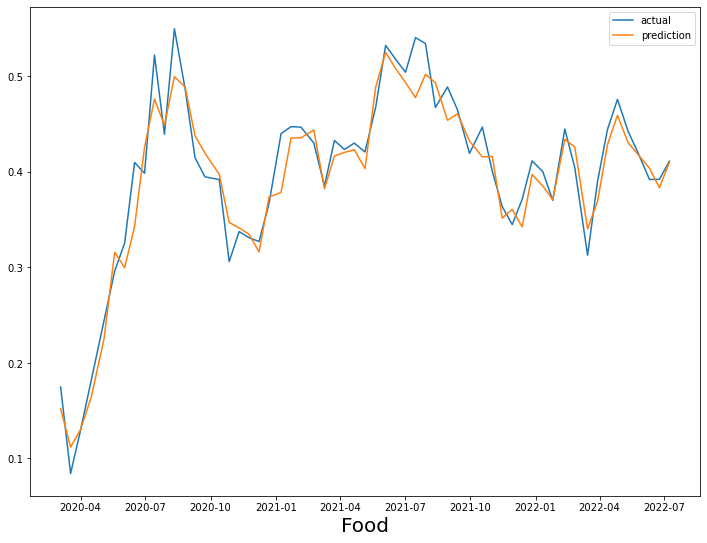

59/59 [==============================] - 1s 2ms/step
Clothing의 test_data의 출력 크기 :  (59, 1)


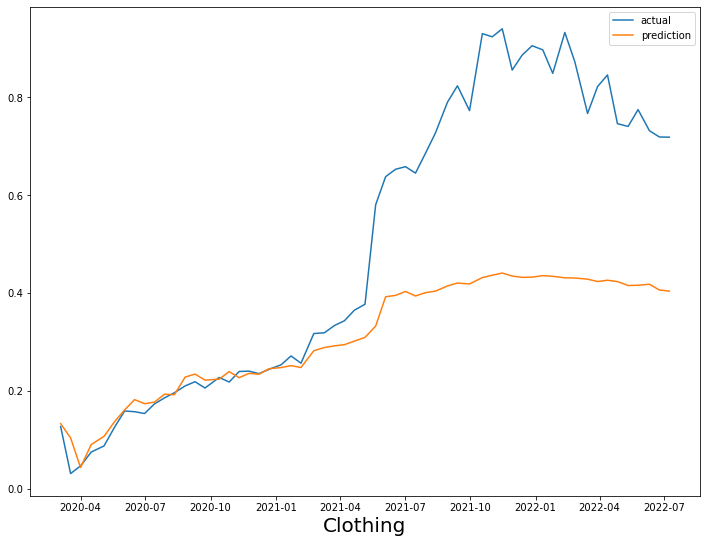

59/59 [==============================] - 1s 2ms/step
Chemical의 test_data의 출력 크기 :  (59, 1)


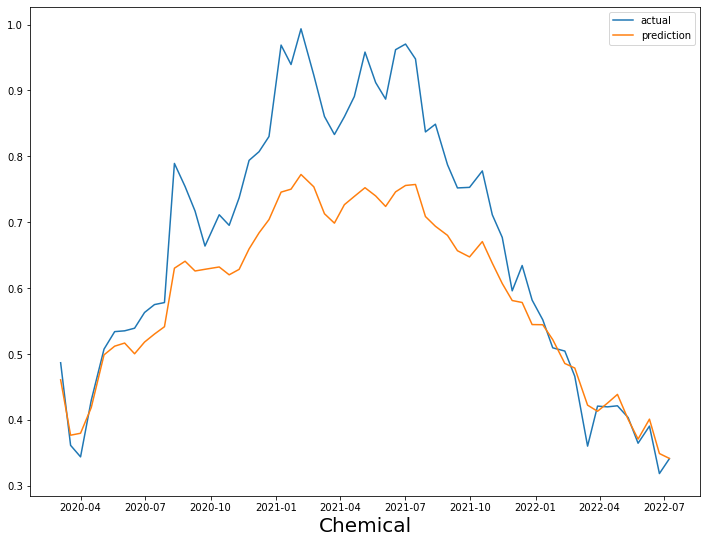

59/59 [==============================] - 1s 2ms/step
Medicine의 test_data의 출력 크기 :  (59, 1)


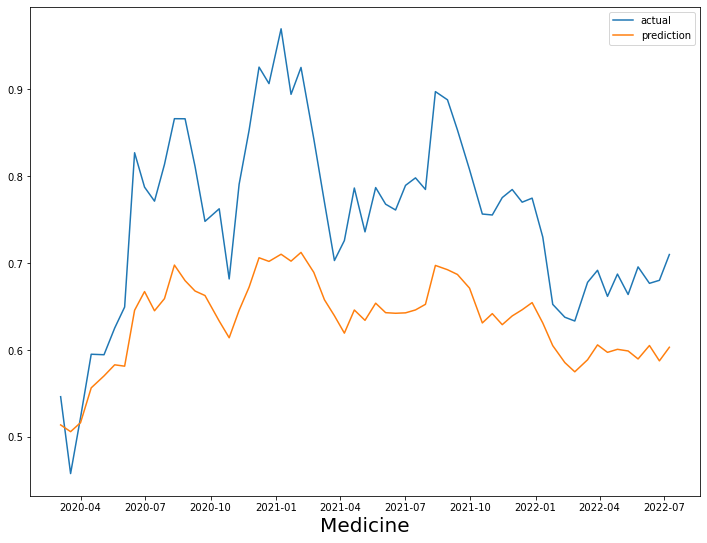

59/59 [==============================] - 1s 2ms/step
Non_Metal의 test_data의 출력 크기 :  (59, 1)


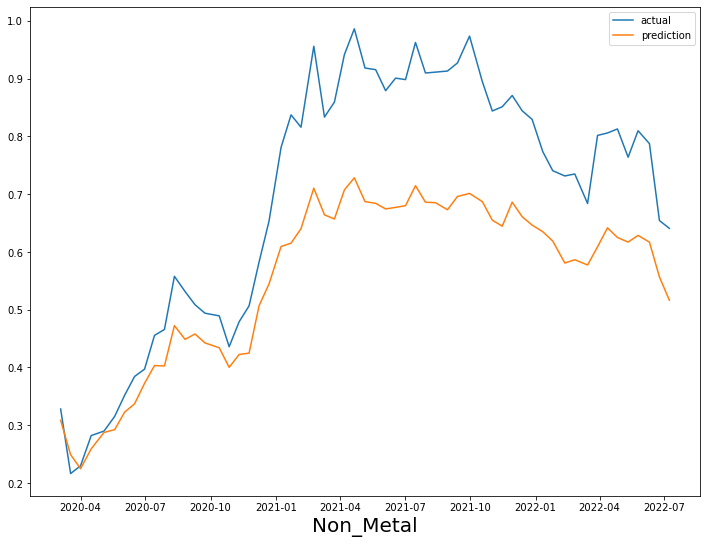

59/59 [==============================] - 1s 2ms/step
Metal의 test_data의 출력 크기 :  (59, 1)


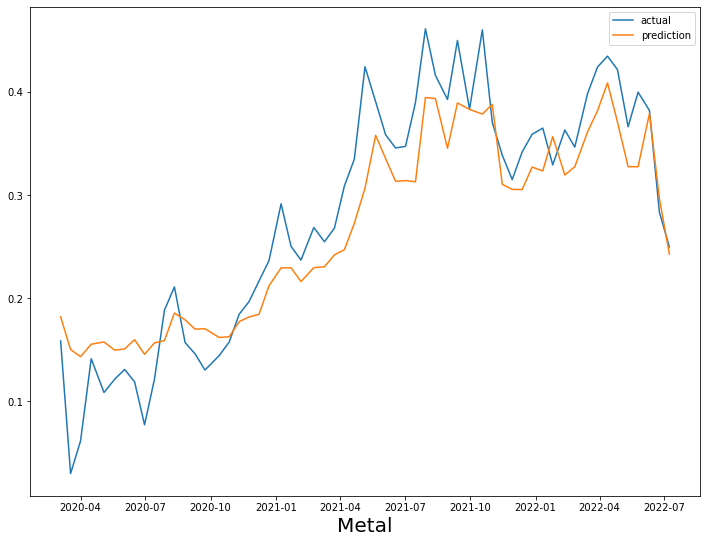

59/59 [==============================] - 1s 2ms/step
Machine의 test_data의 출력 크기 :  (59, 1)


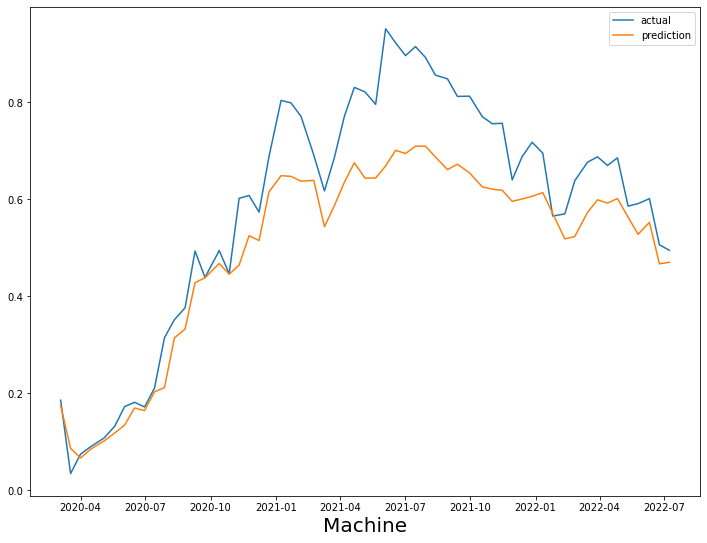

59/59 [==============================] - 1s 2ms/step
Electronic의 test_data의 출력 크기 :  (59, 1)


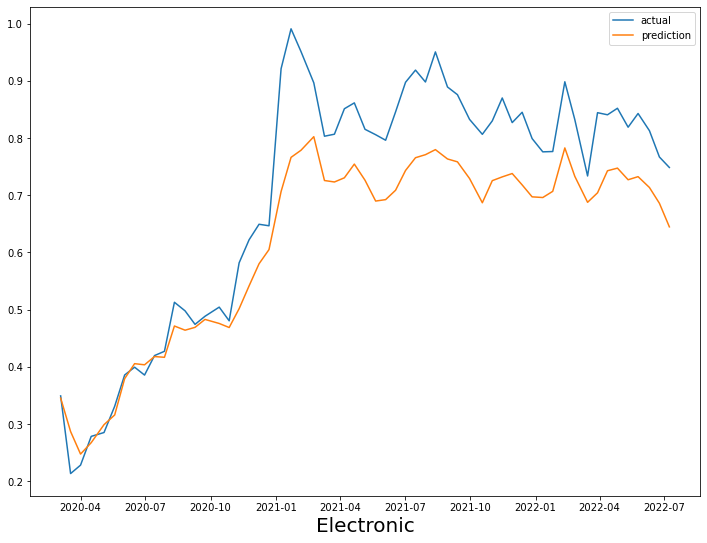

59/59 [==============================] - 1s 2ms/step
Construction의 test_data의 출력 크기 :  (59, 1)


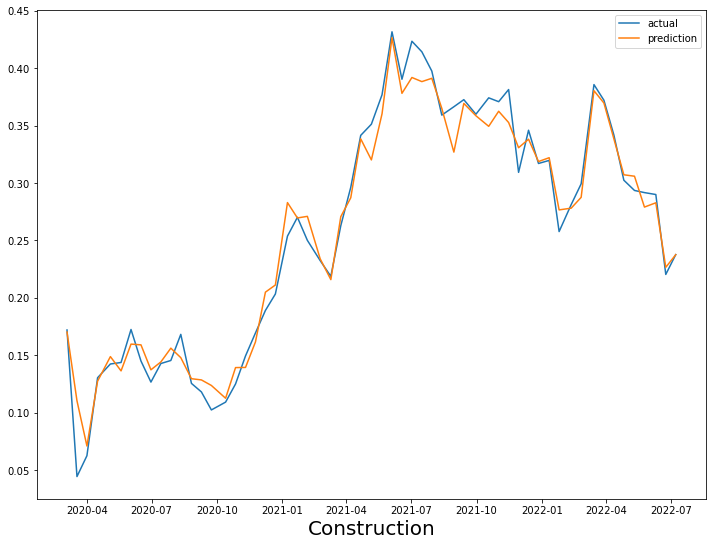

59/59 [==============================] - 1s 2ms/step
Transport의 test_data의 출력 크기 :  (59, 1)


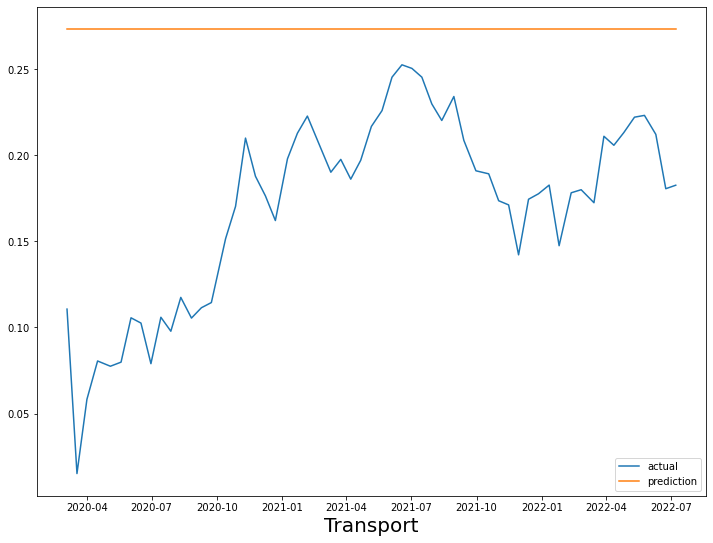

59/59 [==============================] - 1s 2ms/step
Distribution의 test_data의 출력 크기 :  (59, 1)


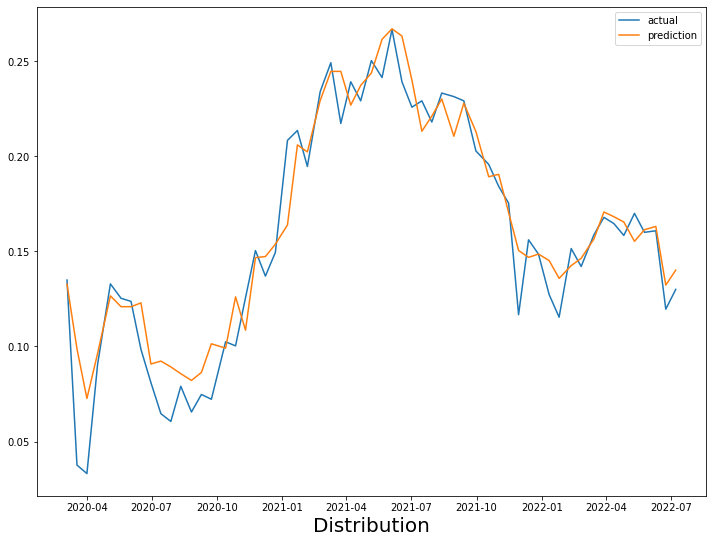

59/59 [==============================] - 1s 2ms/step
Power의 test_data의 출력 크기 :  (59, 1)


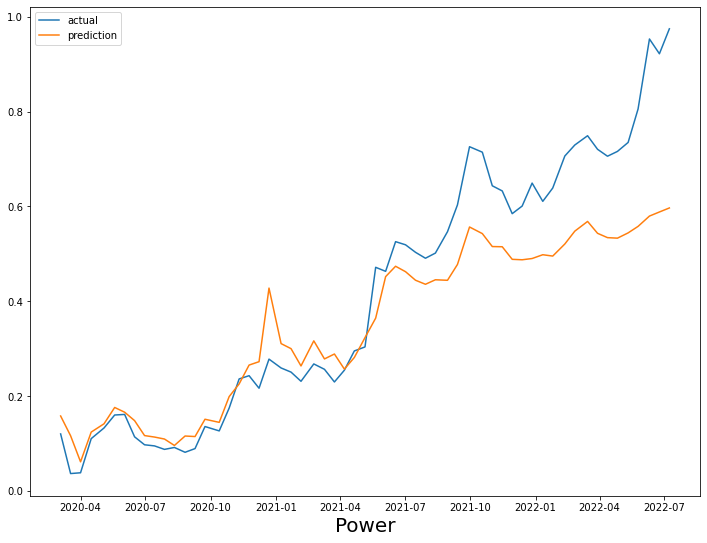

59/59 [==============================] - 1s 2ms/step
Tele의 test_data의 출력 크기 :  (59, 1)


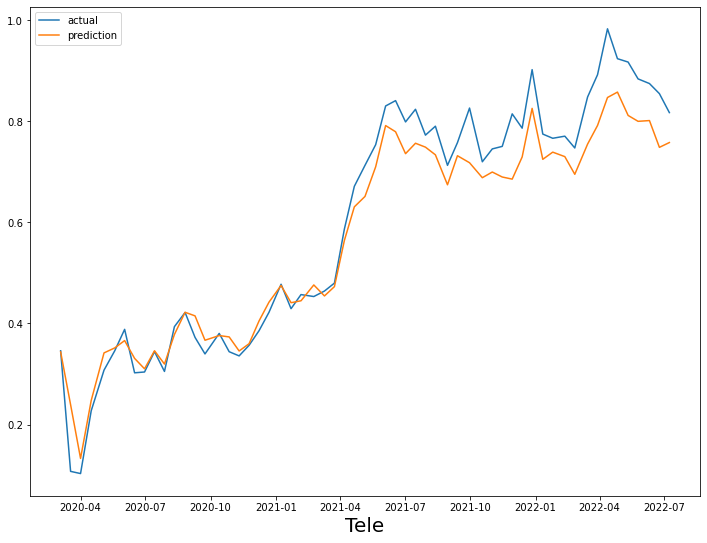

59/59 [==============================] - 1s 2ms/step
Finance의 test_data의 출력 크기 :  (59, 1)


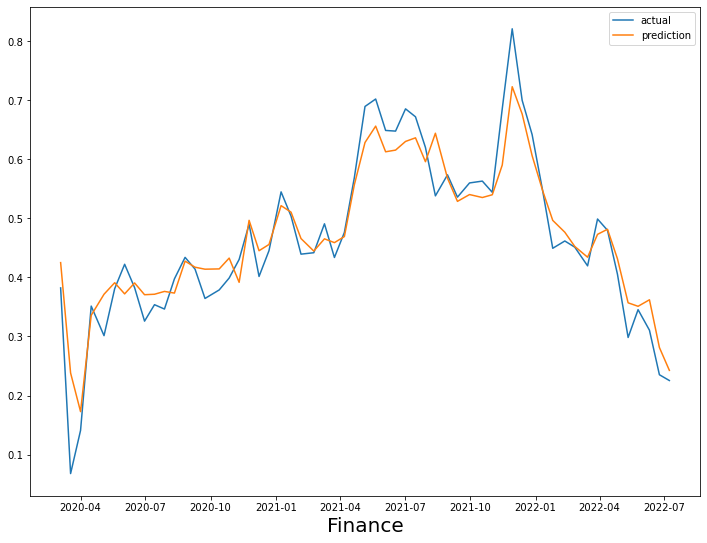

59/59 [==============================] - 1s 2ms/step
Brokerage의 test_data의 출력 크기 :  (59, 1)


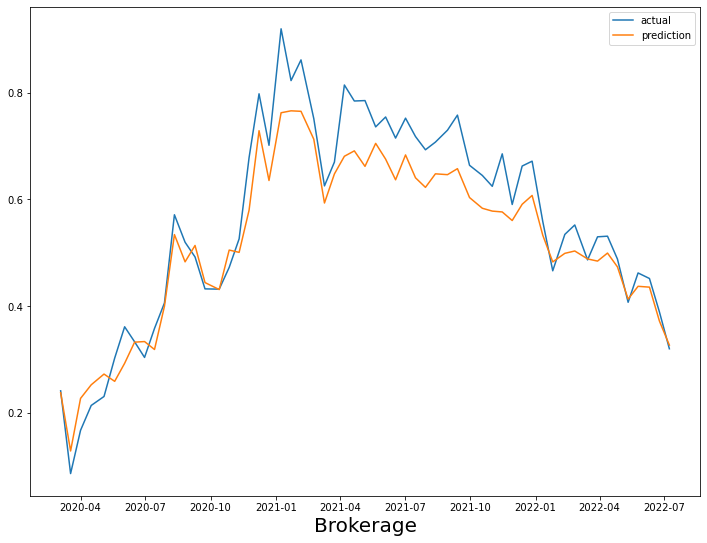

59/59 [==============================] - 1s 2ms/step
Insurer의 test_data의 출력 크기 :  (59, 1)


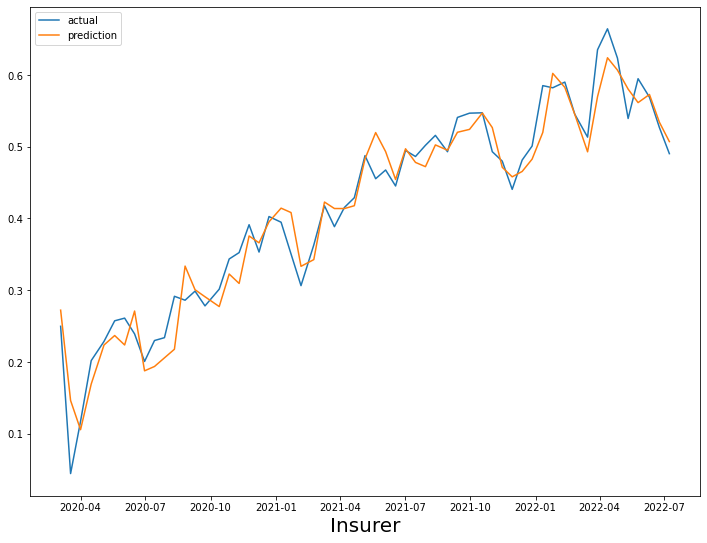

59/59 [==============================] - 1s 2ms/step
Service의 test_data의 출력 크기 :  (59, 1)


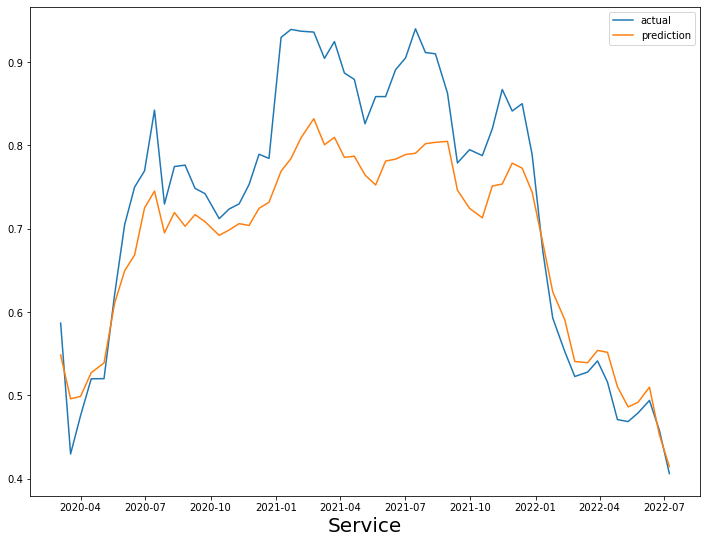

59/59 [==============================] - 1s 2ms/step
Manufacturer의 test_data의 출력 크기 :  (59, 1)


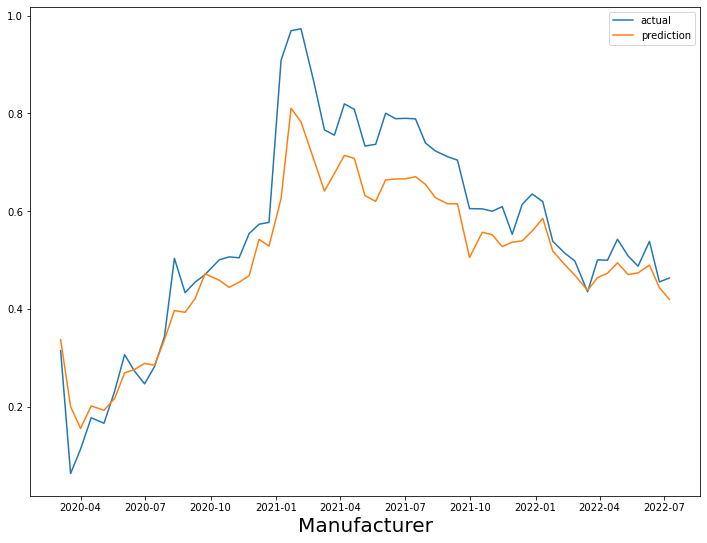

In [16]:
for sector_name, model in model_dic.items():
    df_일자 = (y_test_dic[sector_name].index)[10::10]
    pred = model.predict(tf_dataset_test_dic[sector_name])
    print(f'{sector_name}의 test_data의 출력 크기 : ' ,pred.shape)
    plt.figure(figsize=(12, 9))
    plt.xlabel(sector_name, fontdict={'size': 20})
    plt.plot(df_일자,np.asarray(y_test_dic[sector_name])[10::10], label='actual')
    plt.plot(df_일자,pred, label='prediction')
    plt.legend()
    plt.show()

In [17]:
with open('filename_dic.pickle', 'wb') as f:
    pickle.dump(filename_dic,f)

# 히스토리 출력

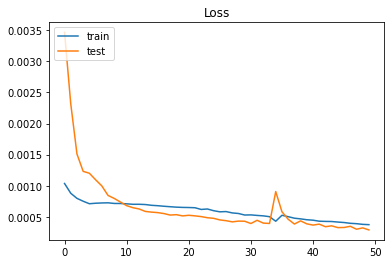

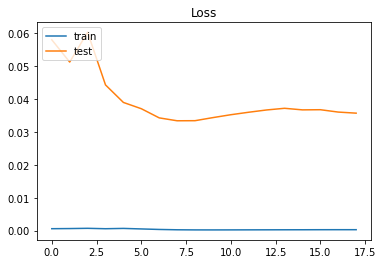

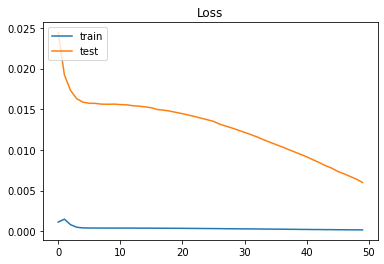

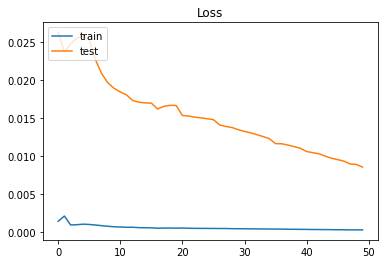

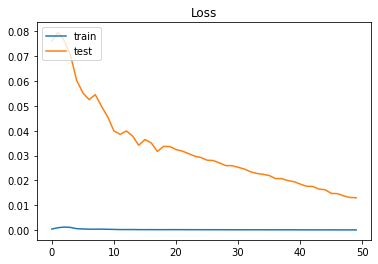

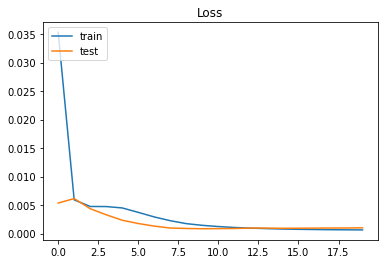

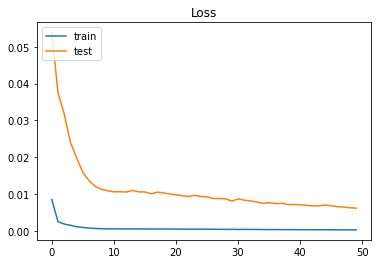

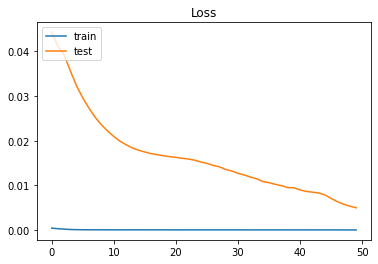

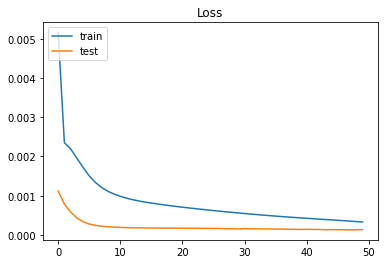

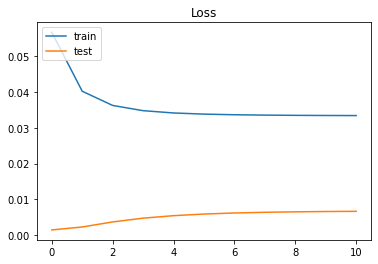

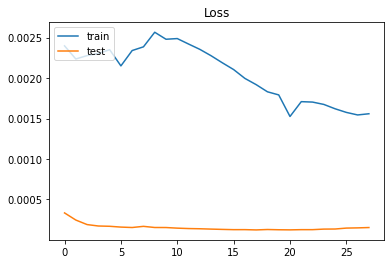

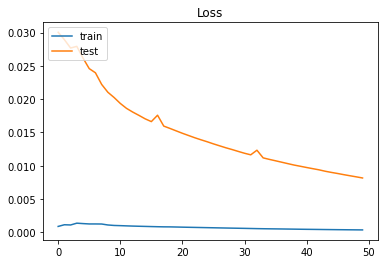

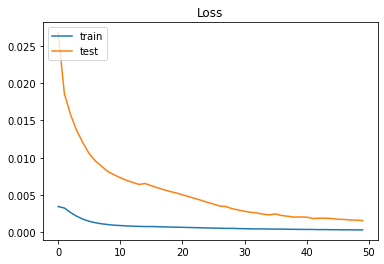

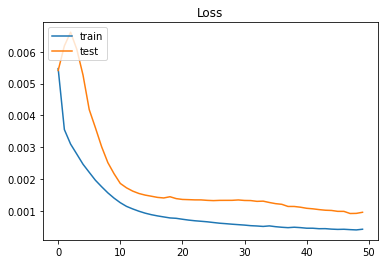

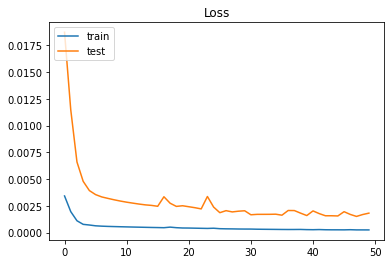

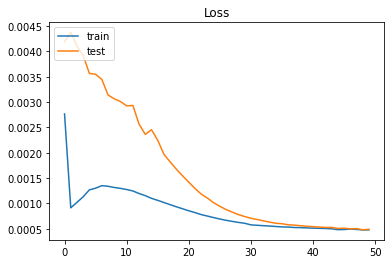

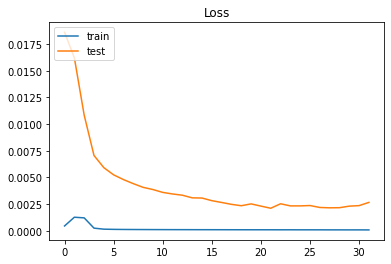

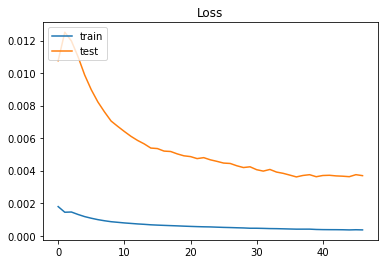

In [18]:
for sector_name, hist in history_dic.items():
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

# 모델 성능 평가

In [24]:
score_dic = {}
for sector_name, model in model_dic.items():
    score = model.evaluate(tf_dataset_test_dic[sector_name])
    score_dic[sector_name] = score
    print(f'{sector_name}모델의 성능 지표 : MSE =  {score[1]:0.4f}, loss= {score[0]:0.4f}')

59/59 [==============================] - 0s 2ms/step - loss: 2.8920e-04 - mse: 5.7839e-04
Food모델의 성능 지표 : MSE =  0.0006, loss= 0.0003
59/59 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0713
Clothing모델의 성능 지표 : MSE =  0.0713, loss= 0.0357
59/59 [==============================] - 0s 2ms/step - loss: 0.0060 - mse: 0.0120
Chemical모델의 성능 지표 : MSE =  0.0120, loss= 0.0060
59/59 [==============================] - 0s 2ms/step - loss: 0.0085 - mse: 0.0171
Medicine모델의 성능 지표 : MSE =  0.0171, loss= 0.0085
59/59 [==============================] - 0s 2ms/step - loss: 0.0130 - mse: 0.0261
Non_Metal모델의 성능 지표 : MSE =  0.0261, loss= 0.0130
59/59 [==============================] - 0s 2ms/step - loss: 9.9524e-04 - mse: 0.0020
Metal모델의 성능 지표 : MSE =  0.0020, loss= 0.0010
59/59 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 0.0125
Machine모델의 성능 지표 : MSE =  0.0125, loss= 0.0062
59/59 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 0.0100
Ele